In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#add path to train and test dataset

train_path = 'drive/MyDrive/DL1/DL1_audio/Input data/audio data/train/'
test_path = 'drive/MyDrive/DL1/DL1_audio/Input data/audio data/test/'

## Create dataset

In [ ]:
def load_data(train_path, test_path):
    
    # filenames for train and test data
    train_files = []
    for filename in os.listdir(train_path):
        train_files.append(filename)
    
    test_files = []
    for filename in os.listdir(test_path):
        test_files.append(filename)
    
    # gender column for train and test data
    train_gender = []
    for filename in os.listdir(train_path):
        train_gender.append('male' if filename[3:4]=='m' else 'female')
    
    test_gender = []
    for filename in os.listdir(test_path):
        test_gender.append('male' if filename[3:4]=='m' else 'female')
        
    # language column for train and test data
    train_language = []
    for filename in os.listdir(train_path):
        train_language.append(filename[:2]) 
        
    test_language = []
    for filename in os.listdir(test_path):
        test_language.append(filename[:2]) 
        
    train_data = {'train_filename': train_files,
                   'language': train_language,
                   'gender': train_gender}
    
    test_data = {'test_filename': test_files,
                   'language': test_language,
                   'gender': test_gender}
    
    # make dataframe
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    # combine gender and language into labels
    train_df['labels'] = train_df['language'] + ', ' + train_df['gender']
    test_df['labels'] = test_df['language'] + ', ' + test_df['gender']
    
    return train_df, test_df

In [ ]:
# create train and test df

train_data, test_data = load_data(train_path, test_path)

## Encode Labels

In [ ]:
def encoder(train_labels, test_labels):
    
    label_encoder = LabelEncoder()
    
    # Labelencode train and test labels
    train_encoded = label_encoder.fit_transform(train_labels)
    train_data['Encoded_labels'] = train_encoded
    
    test_encoded = label_encoder.fit_transform(test_labels)
    test_data['Encoded_labels'] = test_encoded
    
    train_encoded = train_encoded.reshape(-1, 1)
    test_encoded = test_encoded.reshape(-1, 1)
    
    # OneHotEncode encoded labels
    ohe = OneHotEncoder()
    
    train_ohe = ohe.fit_transform(train_encoded).toarray()
    train_data_encoded = pd.concat([train_data, pd.DataFrame(train_ohe)], axis=1)

    
    test_ohe = ohe.fit_transform(test_encoded).toarray()
    test_data_encoded = pd.concat([test_data, pd.DataFrame(test_ohe)], axis=1)


    return train_data_encoded, test_data_encoded

In [ ]:
# encode train and test labels

train_data, test_data = encoder(train_data['labels'], test_data['labels'])

In [ ]:
train_data

train_filename  ...    0
0      de_f_bce247cbc0fe8ff27de25b3adf154d92.fragment...  ...  1.0
1      de_f_bce247cbc0fe8ff27de25b3adf154d92.fragment...  ...  1.0
2      de_f_d94712992f41e3d8d21f22274b3d8fd9.fragment...  ...  1.0
3      de_f_d94712992f41e3d8d21f22274b3d8fd9.fragment...  ...  1.0
4      de_f_bce247cbc0fe8ff27de25b3adf154d92.fragment...  ...  1.0
...                                                  ...  ...  ...
10575  de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...  ...  1.0
10576  de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...  ...  1.0
10577  de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...  ...  1.0
10578  de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...  ...  1.0
10579  de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...  ...  1.0

[10580 rows x 6 columns]

## Load Audio data

In [ ]:
def load_audio(train_path, test_path):
    
    # add time series data and sample rate for train audio files
    time_series_train = []
    num_samples_train = []
    for filename in train_data['train_filename'].values:
        data, samplerate = librosa.load(train_path+filename)
        time_series_train.append(data)
        num_samples_train.append(samplerate)
        
    reduced_train_data['Time_Series'] = time_series_train
    reduced_train_data['Num_Samples'] = num_samples_train
        
    # add time series data and sample rate for test audio files
    time_series_test = []
    num_samples_test = []
    for filename in test_data['test_filename'].values:
        data, samplerate = librosa.load(test_path+filename)
        time_series_test.append(data)
        num_samples_test.append(samplerate)
        
    test_data['Time_Series'] = time_series_test
    test_data['Num_Samples'] = num_samples_test
        
    return reduced_train_data, test_data

## Reduce train data

In [ ]:
def stratify(train_data):
    
    # reduce train data using stratified split - 50% every split
    X_train, X_test, y_train, y_test = train_test_split(train_data, 
                                                        train_data['labels'], 
                                                        stratify = train_data['labels'], 
                                                        test_size = 0.5, 
                                                        random_state = 0)
    X_train = X_train.reset_index(drop = True)
    
    return X_train

In [ ]:
# split train data by 50%

train_data = stratify(train_data)

In [ ]:
# split train data by additional 25%, balance data by stratifying with labels
train_data['labels'].value_counts()

en, female    3045
es, male      3045
en, male      3045
de, male      3045
es, female    3045
de, female    3045
Name: labels, dtype: int64

In [ ]:
# load audio time series and sample rate

train_data, test_data = load_audio(train_path, test_path)

In [ ]:
train_data.head()

train_filename language  gender  \
0  en_f_9a47e3d56398b8108f59385aab8bbe87.fragment...       en  female   
1  es_m_b8e0e6f56f02e6f8f79cc360958e5982.fragment...       es    male   
2  en_m_597da7d934dbb4df3da45acf11536350.fragment...       en    male   
3  de_m_df90bffac026f705f4a99871d71684f1.fragment...       de    male   
4  es_f_53b555eab2b3baada380f7d3ede20b20.fragment...       es  female   

       labels  Encoded_labels    0    1    2    3    4    5  Num_Samples  \
0  en, female               2  0.0  0.0  1.0  0.0  0.0  0.0        22050   
1    es, male               5  0.0  0.0  0.0  0.0  0.0  1.0        22050   
2    en, male               3  0.0  0.0  0.0  1.0  0.0  0.0        22050   
3    de, male               1  0.0  1.0  0.0  0.0  0.0  0.0        22050   
4  es, female               4  0.0  0.0  0.0  0.0  1.0  0.0        22050   

                                         Time_Series  
0  [-0.0211792, -0.029418945, -0.028930664, -0.03...  
1  [0.007232666, 0.0025939941, -0.0014648438, -0....  
2  [-0.037902832, -0.036254883, -0.035064697, -0....  
3  [-0.010528564, -0.020202637, -0.017608643, -0....  
4  [-0.007965088, -0.007965088, 0.0024108887, 0.0...

## Audio features

### MFCC

In [ ]:
def get_mfcc(train_data, test_data):
    
    scaler = StandardScaler()
    
    mfcc_librosa = []
    for i in range(0, len(train_data)):
        mfcc = librosa.feature.mfcc(train_data['Time_Series'][i], sr=train_data['Num_Samples'][i])
        mfcc_sc = scaler.fit_transform(mfcc)
        mfcc_librosa.append(mfcc_sc)
    mfcc_librosa = np.array(mfcc_librosa)
    
    mfcc_librosa_test = []
    for i in range(0, len(test_data)):
        mfcc_test = librosa.feature.mfcc(test_data['Time_Series'][i], sr=test_data['Num_Samples'][i])
        mfcc_sc_test = scaler.fit_transform(mfcc_test)
        mfcc_librosa_test.append(mfcc_sc_test)
    mfcc_librosa_test = np.array(mfcc_librosa_test)
    
    return mfcc_librosa, mfcc_librosa_test

In [ ]:
# generate MFCC train and test features

mfcc_librosa, mfcc_librosa_test = get_mfcc(train_data, test_data)

### Combined MFCC

In [ ]:
def get_combinedmfcc(train_data, test_data):
    
    scaler = StandardScaler()
    
    mfcc_delta2_librosa = []
    for i in range(0, len(train_data)):
        mfcc_d = librosa.feature.mfcc(train_data['Time_Series'][i], sr=train_data['Num_Samples'][i])
        mfcc_delta = librosa.feature.delta(mfcc_d)
        mfcc_delta_delta = librosa.feature.delta(mfcc_d, order=2)
        combined_mfcc_delta = np.concatenate((mfcc_d, mfcc_delta, mfcc_delta_delta))
        combined_mfcc_delta_sc = scaler.fit_transform(combined_mfcc_delta)
        mfcc_delta2_librosa.append(combined_mfcc_delta_sc)
    mfcc_delta2_librosa = np.array(mfcc_delta2_librosa)
    
    mfcc_delta2_librosa_test = []
    for i in range(0, len(test_data)):
        mfcc_d_test = librosa.feature.mfcc(test_data['Time_Series'][i], sr=test_data['Num_Samples'][i])
        mfcc_delta_test = librosa.feature.delta(mfcc_d_test)
        mfcc_delta_delta_test = librosa.feature.delta(mfcc_d, order=2)
        combined_mfcc_delta_test = np.concatenate((mfcc_d_test, mfcc_delta_test, mfcc_delta_delta_test))
        combined_mfcc_delta_sc_test = scaler.fit_transform(combined_mfcc_delta_test)
        mfcc_delta2_librosa_test.append(combined_mfcc_delta_sc_test)
    mfcc_delta2_librosa_test = np.array(mfcc_delta2_librosa_test)
    
    
    return mfcc_delta2_librosa, mfcc_delta2_librosa_test

In [ ]:
# generate Combined MFCC train and test features

mfcc_delta2_librosa, mfcc_delta2_librosa_test = get_combinedmfcc(train_data, test_data)

### Mel Spectrogram

In [ ]:
def get_melspectrogram(train_data, test_data):
    
    scaler = StandardScaler()
    
    mel_librosa = []
    for i in range(0, len(train_data)):
        mel = librosa.feature.melspectrogram(train_data['Time_Series'][i], sr=train_data['Num_Samples'][i])
        mel_sc = scaler.fit_transform(mel)
        mel_librosa.append(mel_sc)
    mel_librosa = np.array(mel_librosa)
    
    mel_librosa_test = []
    for i in range(0, len(test_data)):
        mel_test = librosa.feature.melspectrogram(test_data['Time_Series'][i], sr=test_data['Num_Samples'][i])
        mel_sc_test = scaler.fit_transform(mel_test)
        mel_librosa_test.append(mel_sc_test)
    mel_librosa_test = np.array(mel_librosa_test)
    
    return mel_librosa, mel_librosa_test

In [ ]:
# generate Mel Spectrogram train and test features

mel_librosa, mel_librosa_test = get_melspectrogram(train_data, test_data)

### Spectral Centroid

In [ ]:
def get_spectralcentroid(train_data, test_data):
    
    scaler = StandardScaler()
    
    n_fft = 1024
    hop_length = 512
    
    sc_librosa = []
    for i in range(0, len(train_data)):
        sc = librosa.feature.spectral_centroid(train_data['Time_Series'][i], sr=train_data['Num_Samples'][i],
                                              n_fft=n_fft, hop_length=hop_length)
        sc_sc = scaler.fit_transform(sc)
        sc_librosa.append(sc_sc)
    sc_librosa = np.array(sc_librosa)
    
    sc_librosa_test = []
    for i in range(0, len(test_data)):
        sc_test = librosa.feature.spectral_centroid(test_data['Time_Series'][i], sr=test_data['Num_Samples'][i],
                                                   n_fft=n_fft, hop_length=hop_length)
        sc_sc_test = scaler.fit_transform(sc_test)
        sc_librosa_test.append(sc_sc_test)
    sc_librosa_test = np.array(sc_librosa_test)
    
    return sc_librosa, sc_librosa_test

In [ ]:
# generate spectral centroid train and test features

sc_librosa, sc_librosa_test = get_spectralcentroid(train_data, test_data)

### Zero-crossing Rate

In [ ]:
def get_zcr(train_data, test_data):
    
    scaler = StandardScaler()
    
    hop_length = 512
    
    zcr_librosa = []
    for i in range(0, len(train_data)):
        zcr = librosa.feature.zero_crossing_rate(train_data['Time_Series'][i], hop_length=hop_length)
        zcr_sc = scaler.fit_transform(zcr)
        zcr_librosa.append(zcr_sc)
    zcr_librosa = np.array(zcr_librosa)
    
    zcr_librosa_test = []
    for i in range(0, len(test_data)):
        zcr_test = librosa.feature.mfcc(test_data['Time_Series'][i], hop_length=hop_length)
        zcr_sc_test = scaler.fit_transform(zcr_test)
        zcr_librosa_test.append(zcr_sc_test)
    zcr_librosa_test = np.array(zcr_librosa_test)
    
    return zcr_librosa, zcr_librosa_test

In [ ]:
# generate Zero-crossing rate train and test features

zcr_librosa, zcr_librosa_test = get_zcr(train_data, test_data)

## Save feature and label files

In [ ]:
def save_features(train_feature, test_feature):
    
    train_feature1 = np.save(train_filepath, train_feature)
    print(f'Saved train feature to {train_filepath}')

    test_feature1 = np.save(test_filepath, test_feature)
    print(f'Saved test feature to {test_filepath}')                      
    
    return train_feature1, test_feature1

In [ ]:
def save_labels(train_data, test_data):
    
    train_ohe = (train_data.loc[:, 0:5]).values
    train_ohe_labels = np.save(trainlabel_filepath, train_ohe)
    print(f'Saved train labels to {trainlabel_filepath}')
    
    test_ohe = (test_data.loc[:, 0:5]).values
    test_ohe_labels = np.save(testlabel_filepath, test_ohe)
    print(f'Saved test labels to {testlabel_filepath}')
    
    return train_ohe_labels, test_ohe_labels

## Load feature and label files

In [ ]:
def load_features(train_filepath, test_filepath):
    
    train_feature1 = np.load(train_filepath+'.npy')
    print(f'Load train feature from {train_filepath}')
                           
    test_feature1 = np.load(test_filepath+'.npy')
    print(f'Load test feature from {test_filepath}')

    return train_feature1, test_feature1

In [ ]:
def load_labels(trainlabel_filepath, testlabel_filepath):
    
    train_ohe_labels = np.load(trainlabel_filepath+'.npy')
    print(f'Load train labels from {trainlabel_filepath}')

    test_ohe_labels = np.load(testlabel_filepath+'.npy')
    print(f'Load test labels from {testlabel_filepath}')
    
    return train_ohe_labels, test_ohe_labels

In [ ]:
# set train and test features filepath

train_filepath = 'drive/MyDrive/DL1/DL1_audio/Input data/'
test_filepath = 'drive/MyDrive/DL1/DL1_audio/Input data/'

In [ ]:
# set train and test labels filepath

trainlabel_filepath = 'drive/MyDrive/DL1/DL1_audio/Input data/'
testlabel_filepath = 'drive/MyDrive/DL1/DL1_audio/Input data/'

In [ ]:
# save feature array

combinedmfcc_save, combinedmfcc_test_save = save_features(mfcc_delta2_librosa, mfcc_delta2_librosa_test)

In [ ]:
# save labels

ohe_labels_save, ohe_labels_test_save = save_labels(train_data, test_data)

In [ ]:
combinedmfcc_array.shape

(18270, 60, 431)

In [5]:
# path to input features and labels

path = "drive/MyDrive/DL1/DL1_audio/Input data/"

In [11]:
# load features and labels to Colab

combinedmfcc_array = np.load(path+'combinedmfcc.npy')
combinedmfcc_array_test = np.load(path+'combinedmfcc_test.npy')

ohe_labels_array = np.load(path+'ohe_labels2.npy')
ohe_labels_array_test = np.load(path+'ohe_labels_test2.npy')

## Train test split

In [12]:
X_train_combinedmfcc, X_test_combinedmfcc, y_train_combinedmfcc, y_test_combinedmfcc = train_test_split(combinedmfcc_array, ohe_labels_array, test_size = 0.10, random_state = 0)

In [13]:
y_train_combinedmfcc.shape

(16443, 6)

In [14]:
# reshape to 4D for CNN model, use previous for RNN-LSTM model

X_train_combinedmfcc_reshaped = X_train_combinedmfcc.reshape(-1, 60, 431, 1)
X_test_combinedmfcc_reshaped = X_test_combinedmfcc.reshape(-1, 60, 431, 1)

## NN Models

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from keras import regularizers
import math
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import save_model, load_model

## CNN Models

In [18]:
# CNN Model 1

def cnn_1():
  input_shape = (X_train_combinedmfcc_reshaped.shape[1], X_train_combinedmfcc_reshaped.shape[2], X_train_combinedmfcc_reshaped.shape[3])

  model = Sequential()
  model.add(Conv2D(12,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(32,(5,5), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
  model.add(Conv2D(128,(2,2), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))


  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.0015
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)
  history = model.fit(
                  X_train_combinedmfcc_reshaped,
                  y_train_combinedmfcc,
                  epochs=50,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc_reshaped, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [19]:
cnn_model_1 = cnn_1()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 425, 12)       600       
                                                                 
 batch_normalization_6 (Batc  (None, 54, 425, 12)      48        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 213, 12)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 213, 32)       9632      
                                                                 
 batch_normalization_7 (Batc  (None, 27, 213, 32)      128       
 hNormalization)                                                 
                                                      

In [66]:
# CNN Model 2 - increased conv layer nodes

def cnn_2():
  input_shape = (X_train_combinedmfcc_reshaped.shape[1], X_train_combinedmfcc_reshaped.shape[2], X_train_combinedmfcc_reshaped.shape[3])

  model = Sequential()
  model.add(Conv2D(16,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(16,(5,5), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
  model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))


  adam = Adam()

  model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

  def step_decay(epoch):
      initial_lrate = 0.0015
      drop = 0.9
      epochs_drop = 1
      lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
      return lrate

  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )

  model.summary()
  lrate = LearningRateScheduler(step_decay)


  history = model.fit(
                  X_train_combinedmfcc_reshaped,
                  y_train_combinedmfcc,
                  epochs=50,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc_reshaped, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [67]:
cnn_model_2 = cnn_2()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 54, 425, 16)       800       
                                                                 
 batch_normalization_18 (Bat  (None, 54, 425, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 27, 213, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 27, 213, 16)       6416      
                                                                 
 batch_normalization_19 (Bat  (None, 27, 213, 16)      64        
 chNormalization)                                                
                                                      

In [69]:
# CNN Model 3 - increased input nodes, added additional fully connected layer, adjusted lrate

def cnn_3():
  input_shape = (X_train_combinedmfcc_reshaped.shape[1], X_train_combinedmfcc_reshaped.shape[2], X_train_combinedmfcc_reshaped.shape[3])

  model = Sequential()
  model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(32,(5,5), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
  model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))


  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

  model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)
  
  history = model.fit(
                  X_train_combinedmfcc_reshaped,
                  y_train_combinedmfcc,
                  epochs=50,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc_reshaped, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [70]:
cnn_model_3 = cnn_3()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 54, 425, 32)       1600      
                                                                 
 batch_normalization_24 (Bat  (None, 54, 425, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 27, 213, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 27, 213, 32)       25632     
                                                                 
 batch_normalization_25 (Bat  (None, 27, 213, 32)      128       
 chNormalization)                                                
                                                      

In [71]:
# CNN Model 4 - increased input nodes, decreased conv layers, adjusted lrate

def cnn_4():
  input_shape = (X_train_combinedmfcc_reshaped.shape[1], X_train_combinedmfcc_reshaped.shape[2], X_train_combinedmfcc_reshaped.shape[3])

  model = Sequential()
  model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(32,(5,5), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
  model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))


  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

  model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)
  history = model.fit(
                  X_train_combinedmfcc_reshaped,
                  y_train_combinedmfcc,
                  epochs=50,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc_reshaped, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [72]:
cnn_model_4 = cnn_4()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 54, 425, 32)       1600      
                                                                 
 batch_normalization_29 (Bat  (None, 54, 425, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 27, 213, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 27, 213, 32)       25632     
                                                                 
 batch_normalization_30 (Bat  (None, 27, 213, 32)      128       
 chNormalization)                                                
                                                      

## RNN-LSTM Models

In [81]:
# RNN-LSTM 1 

def rnn_1():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.3))
  model.add(LSTM(64))
  model.add(Dropout(0.3))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler
  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [82]:
rnn_model_1 = rnn_1()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 64)            126976    
                                                                 
 dropout_16 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)              

In [105]:
# RNN-LSTM 2 - increase LSTM nodes, use rmsprop activation function

def rnn_2():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.3))
  model.add(LSTM(64))
  model.add(Dropout(0.3))

  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler

  def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [106]:
rnn_model_2 = rnn_2()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 60, 128)           286720    
                                                                 
 dropout_36 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_34 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 64)              

In [111]:
# RNN-LSTM Model 3 - decrease LSTM and dense layer nodes, use adam activation function

def rnn_3():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.2))
  model.add(LSTM(64))
  model.add(Dropout(0.2))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler
  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.0015
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [112]:
rnn_model_3 = rnn_3()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 60, 64)            126976    
                                                                 
 dropout_51 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_40 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dropout_53 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 32)              

In [8]:
# RNN-LSTM Model 4 - decrease LSTM and increase dense layer nodes, adam activation function

def rnn_4():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.3))
  model.add(LSTM(32))
  model.add(Dropout(0.3))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler
  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.0015
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [11]:
rnn_model_4 = rnn_4()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            59392     
                                                                 
 dropout (Dropout)           (None, 60, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4

In [12]:
# RNN-LSTM Model 5 - add dense layer, decrease dropout, rmsprop activation function

def rnn_5():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.2))
  model.add(LSTM(32))
  model.add(Dropout(0.2))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler
  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.0015
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [13]:
rnn_model_5 = rnn_5()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 32)            59392     
                                                                 
 dropout_5 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [14]:
# RNN-LSTM Model 6 - increase LSTM layer, rmsprop activation function

def rnn_6():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.2))
  model.add(LSTM(128))
  model.add(Dropout(0.2))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler
  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.0015
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [15]:
rnn_model_6 = rnn_6()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 128)           286720    
                                                                 
 dropout_11 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [16]:
# RNN-LSTM Model 7 - increase LSTM layer, add dense layer, rmsprop activation function

def rnn_7():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.2))
  model.add(LSTM(256))
  model.add(Dropout(0.2))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler
  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.0015
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [17]:
rnn_model_7 = rnn_7()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 256)           704512    
                                                                 
 dropout_17 (Dropout)        (None, 60, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)               

In [20]:
# RNN-LSTM Model 8 - increase LSTM layer, add dense layer, rmsprop activation function

def rnn_8():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(512, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.2))
  model.add(LSTM(512))
  model.add(Dropout(0.2))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler
  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.0015
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [21]:
rnn_model_8 = rnn_8()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 512)           1933312   
                                                                 
 dropout_32 (Dropout)        (None, 60, 512)           0         
                                                                 
 lstm_11 (LSTM)              (None, 512)               2099200   
                                                                 
 dropout_33 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                32832     
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 64)               

In [30]:
# RNN-LSTM Model 9 - increase LSTM layer, rmsprop activation function

def rnn_9():
  input_shape = (X_train_combinedmfcc.shape[1], X_train_combinedmfcc.shape[2])

  model = Sequential()
  model.add(LSTM(1024, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.2))
  model.add(LSTM(1024))
  model.add(Dropout(0.2))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation='softmax'))

  import math
  from keras.callbacks import LearningRateScheduler
  adam = Adam()
  def step_decay(epoch):
    initial_lrate = 0.0015
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



  checkpoint = ModelCheckpoint('model.h5',
                  monitor='val_acc',
                  verbose=0,
                  save_best_only=True,
                  mode='max'
                  )
  model.summary()

  lrate = LearningRateScheduler(step_decay)

  history = model.fit(
                  X_train_combinedmfcc,
                  y_train_combinedmfcc,
                  epochs=100,
                  callbacks=[checkpoint, lrate],
                  verbose=1,
                  validation_data=(X_test_combinedmfcc, y_test_combinedmfcc),
                  batch_size=32)
  
  return history

In [113]:
# save CNN Models

save_model(cnn_model_1.model, path+'CNN Models/Model 1/')
save_model(cnn_model_2.model, path+'CNN Models/Model 2/')
save_model(cnn_model_3.model, path+'CNN Models/Model 3/')
save_model(cnn_model_4.model, path+'CNN Models/Model 4/')

INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/CNN Models/Model 1/assets
INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/CNN Models/Model 2/assets
INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/CNN Models/Model 3/assets
INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/CNN Models/Model 4/assets


In [23]:
# save RNN Models

save_model(rnn_model_1.model, path+'RNN Models/Model 1/')
save_model(rnn_model_2.model, path+'RNN Models/Model 2/')
save_model(rnn_model_3.model, path+'RNN Models/Model 3/')
save_model(rnn_model_4.model, path+'RNN Models/Model 4/')
save_model(rnn_model_5.model, path+'RNN Models/Model 5/')
save_model(rnn_model_6.model, path+'RNN Models/Model 6/')
save_model(rnn_model_7.model, path+'RNN Models/Model 7/')
save_model(rnn_model_8.model, path+'RNN Models/Model 8/')

INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 6/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 6/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 7/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 7/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 8/assets


INFO:tensorflow:Assets written to: drive/MyDrive/DL1/DL1_audio/Input data/RNN Models/Model 8/assets


## Plot Model Accuracy and Loss

In [25]:
 def plot_model(model, title): 
  # list all the data in history
  print(model.history.keys())

  # Plot the accuracy for both train and validation set
  plt.subplots() # open a new plot
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title(title + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.show()

  # Plot the loss for both train and validation set
  plt.subplots() # open a new plot
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title(title + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


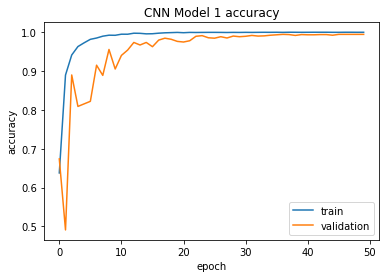

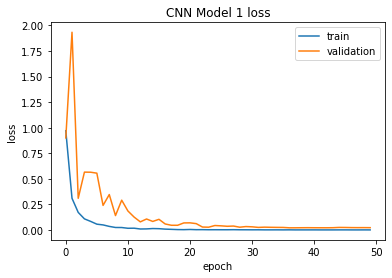

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


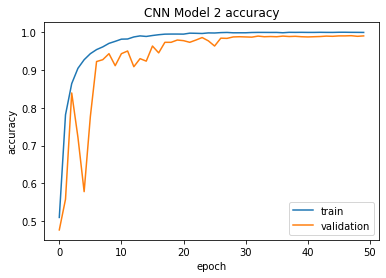

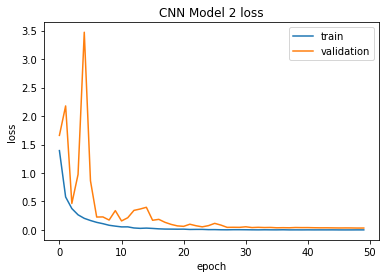

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


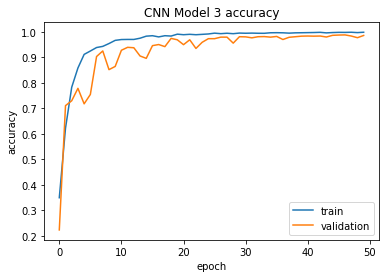

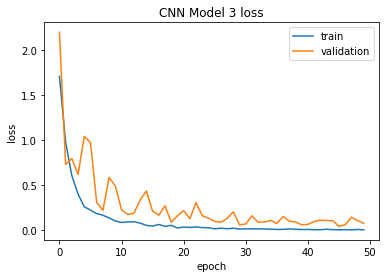

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


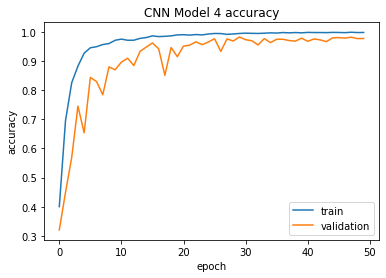

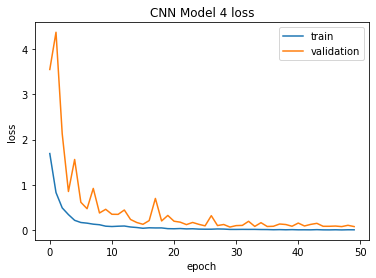

In [126]:
# Plot CNN Models

plot_model(cnn_model_1, 'CNN Model 1')
plot_model(cnn_model_2, 'CNN Model 2')
plot_model(cnn_model_3, 'CNN Model 3')
plot_model(cnn_model_4, 'CNN Model 4')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


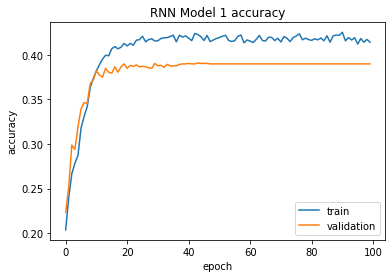

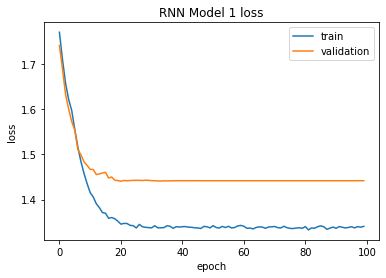

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


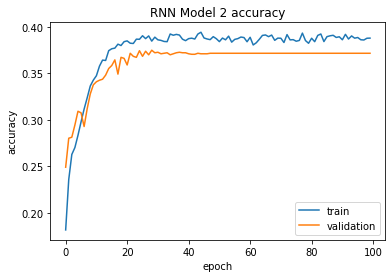

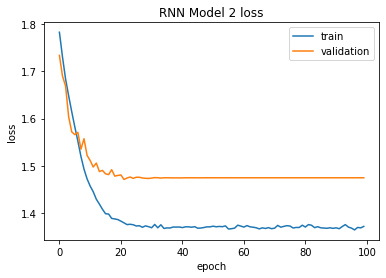

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


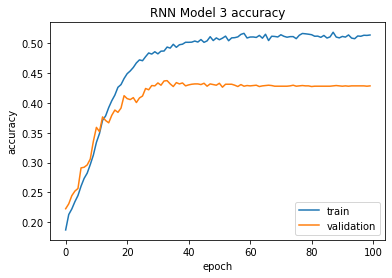

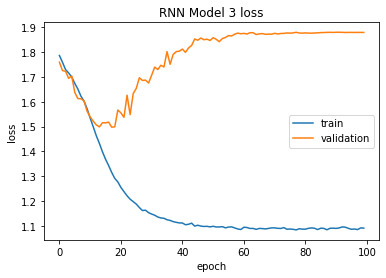

In [127]:
# Plot RNN Models

plot_model(rnn_model_1, 'RNN Model 1')
plot_model(rnn_model_2, 'RNN Model 2')
plot_model(rnn_model_3, 'RNN Model 3')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


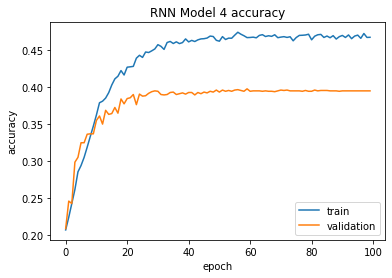

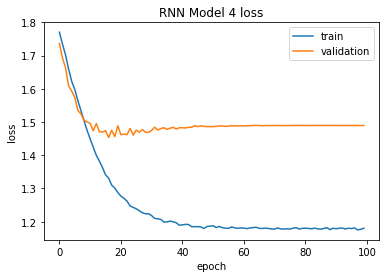

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


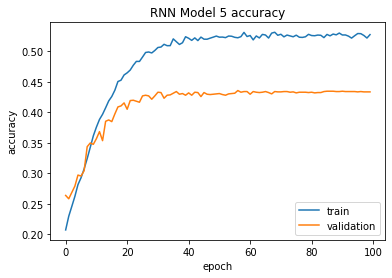

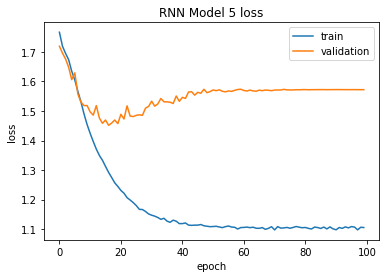

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


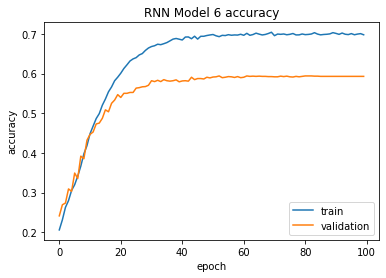

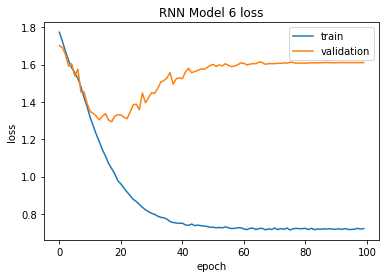

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


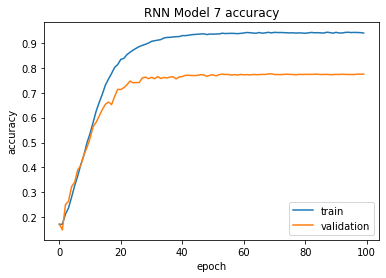

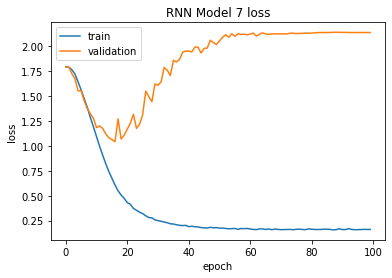

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


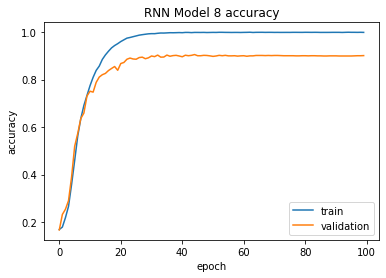

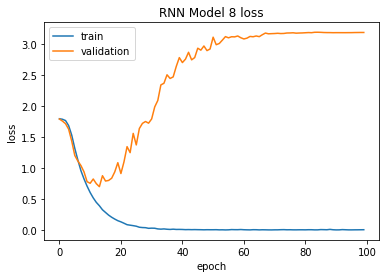

In [26]:
plot_model(rnn_model_4, 'RNN Model 4')
plot_model(rnn_model_5, 'RNN Model 5')
plot_model(rnn_model_6, 'RNN Model 6')
plot_model(rnn_model_7, 'RNN Model 7')
plot_model(rnn_model_8, 'RNN Model 8')

## Model Test Accuracy

In [27]:
def test_predictions(model):
  predictions = model.model.predict(X_test_combinedmfcc[0:10])

  actual = np.argmax(y_test_combinedmfcc, axis=1)

  # Generate arg maxes for predictions
  classes = np.argmax(predictions, axis = 1)
  print('Actual: %s, Predicted: %s' % (actual[0:10], classes[0:10]))

In [16]:
def test_accuracy(model, title):
  y_pred = model.predict(combinedmfcc_array_test)

  y_test1 = []
  for i in range(0,len(ohe_labels_array_test)):
      argmax = np.argmax(ohe_labels_array_test[i,:])
      y_test1.append(argmax)

  y_pred1 = []
  for i in range(0,len(ohe_labels_array_test)):
      argmax = np.argmax(y_pred[i,:])
      y_pred1.append(argmax)

  cm = confusion_matrix(y_test1, y_pred1)

  ax = plt.figure(figsize=(10, 7))
  ax = plt.title(title + ' Confusion Matrix')
  ax = plt.subplot()
  print(sns.heatmap(cm, annot=True))
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.xaxis.set_ticklabels(['German, F', 'German, M', 'English, F', 'English, M', 'Spanish, F', 'Spanish, M']); ax.yaxis.set_ticklabels(['German, F', 'German, M', 'English, F', 'English, M', 'Spanish, F', 'Spanish, M'])
  
  print(classification_report(y_test1, y_pred1, target_names = ['German, F', 'German, M', 'English, F', 'English, M', 'Spanish, F', 'Spanish, M']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.57      1.00      0.73        90
   German, M       0.87      0.61      0.72        90
  English, F       0.94      0.92      0.93        90
  English, M       0.92      0.96      0.94        90
  Spanish, F       0.95      0.66      0.78        90
  Spanish, M       1.00      0.84      0.92        90

    accuracy                           0.83       540
   macro avg       0.88      0.83      0.83       540
weighted avg       0.88      0.83      0.83       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.86      0.99      0.92        90
   German, M       0.94      0.81      0.87        90
  English, F       0.97      0.96      0.96        90
  English, M       0.57      1.00      0.73        90
  Spanish, F       0.91      0.94      0.93        90
  Spanish, M       1.00      0.21      0.35        90

    accuracy                           0.82       540
   macro avg       0.87      0.82      0.79       540
weighted avg       0.87      0.82      0.79       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.53      0.99      0.69        90
   German, M       0.92      0.89      0.90        90
  English, F       0.97      0.40      0.57        90
  English, M       0.96      0.96      0.96        90
  Spanish, F       0.75      0.80      0.77        90
  Spanish, M       0.95      0.67      0.78        90

    accuracy                           0.78       540
   macro avg       0.85      0.78      0.78       540
weighted avg       0.85      0.78      0.78       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.55      1.00      0.71        90
   German, M       0.81      0.43      0.57        90
  English, F       0.96      0.90      0.93        90
  English, M       0.98      0.91      0.94        90
  Spanish, F       0.80      0.78      0.79        90
  Spanish, M       0.97      0.78      0.86        90

    accuracy                           0.80       540
   macro avg       0.84      0.80      0.80       540
weighted avg       0.84      0.80      0.80       540



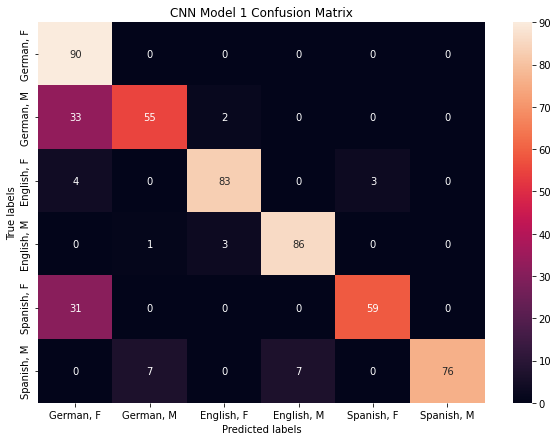

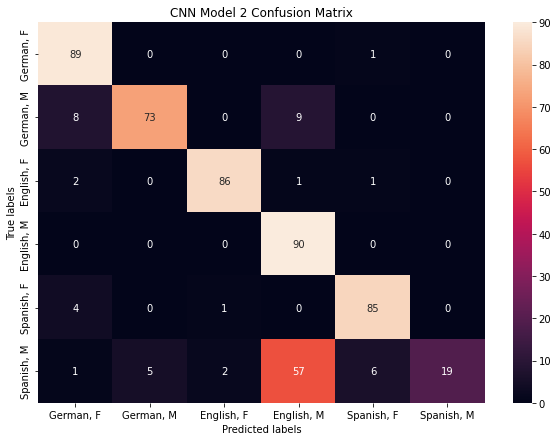

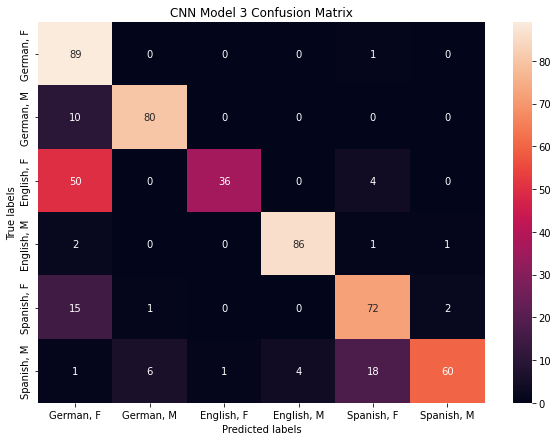

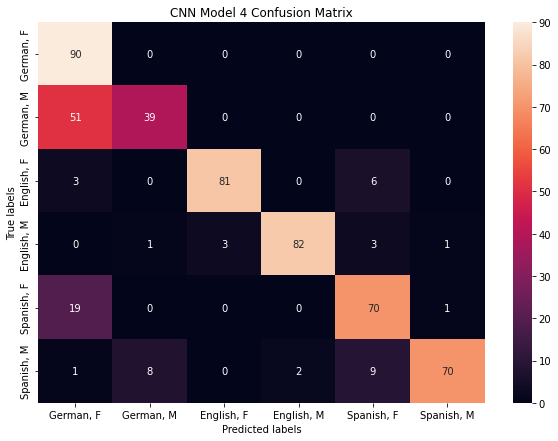

In [17]:
# CNN Models 

test_accuracy(cnn_model_1, 'CNN Model 1')
test_accuracy(cnn_model_2, 'CNN Model 2')
test_accuracy(cnn_model_3, 'CNN Model 3')
test_accuracy(cnn_model_4, 'CNN Model 4')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.00      0.00      0.00        90
   German, M       0.31      0.23      0.27        90
  English, F       0.44      0.57      0.50        90
  English, M       0.53      0.60      0.56        90
  Spanish, F       0.11      0.07      0.08        90
  Spanish, M       0.17      0.19      0.18        90

    accuracy                           0.28       540
   macro avg       0.26      0.28      0.26       540
weighted avg       0.26      0.28      0.26       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.00      0.00      0.00        90
   German, M       0.21      0.12      0.15        90
  English, F       0.05      0.08      0.06        90
  English, M       0.38      0.38      0.38        90
  Spanish, F       0.07      0.08      0.08        90
  Spanish, M       0.50      0.11      0.18        90

    accuracy                           0.13       540
   macro avg       0.20      0.13      0.14       540
weighted avg       0.20      0.13      0.14       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.00      0.00      0.00        90
   German, M       0.38      0.17      0.23        90
  English, F       0.03      0.03      0.03        90
  English, M       0.33      0.31      0.32        90
  Spanish, F       0.01      0.01      0.01        90
  Spanish, M       0.00      0.00      0.00        90

    accuracy                           0.09       540
   macro avg       0.12      0.09      0.10       540
weighted avg       0.12      0.09      0.10       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.14      0.13      0.14        90
   German, M       0.20      0.06      0.09        90
  English, F       0.51      0.83      0.63        90
  English, M       0.31      0.42      0.36        90
  Spanish, F       0.08      0.07      0.07        90
  Spanish, M       0.06      0.06      0.06        90

    accuracy                           0.26       540
   macro avg       0.22      0.26      0.22       540
weighted avg       0.22      0.26      0.22       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.02      0.02      0.02        90
   German, M       0.19      0.08      0.11        90
  English, F       0.30      0.41      0.35        90
  English, M       0.23      0.26      0.24        90
  Spanish, F       0.05      0.04      0.05        90
  Spanish, M       0.14      0.14      0.14        90

    accuracy                           0.16       540
   macro avg       0.16      0.16      0.15       540
weighted avg       0.16      0.16      0.15       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.02      0.02      0.02        90
   German, M       0.16      0.14      0.15        90
  English, F       0.34      0.36      0.35        90
  English, M       0.14      0.04      0.07        90
  Spanish, F       0.13      0.12      0.12        90
  Spanish, M       0.46      0.63      0.53        90

    accuracy                           0.22       540
   macro avg       0.21      0.22      0.21       540
weighted avg       0.21      0.22      0.21       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.03      0.04      0.03        90
   German, M       0.20      0.19      0.19        90
  English, F       0.76      0.32      0.45        90
  English, M       0.25      0.17      0.20        90
  Spanish, F       0.02      0.02      0.02        90
  Spanish, M       0.11      0.12      0.11        90

    accuracy                           0.14       540
   macro avg       0.23      0.14      0.17       540
weighted avg       0.23      0.14      0.17       540



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

   German, F       0.12      0.22      0.15        90
   German, M       0.39      0.18      0.24        90
  English, F       0.80      0.58      0.67        90
  English, M       0.00      0.00      0.00        90
  Spanish, F       0.08      0.09      0.08        90
  Spanish, M       0.20      0.28      0.23        90

    accuracy                           0.22       540
   macro avg       0.26      0.22      0.23       540
weighted avg       0.26      0.22      0.23       540



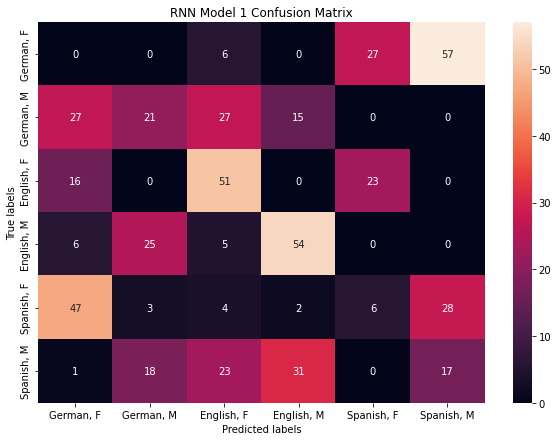

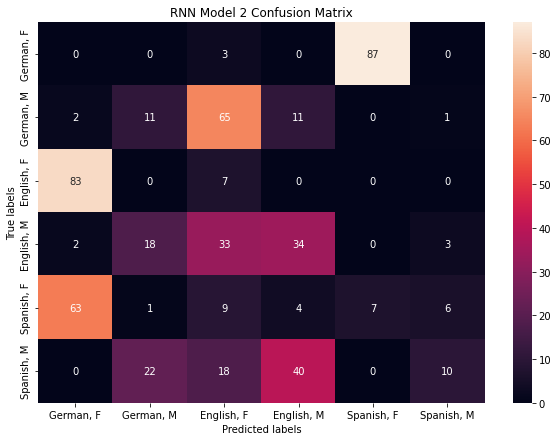

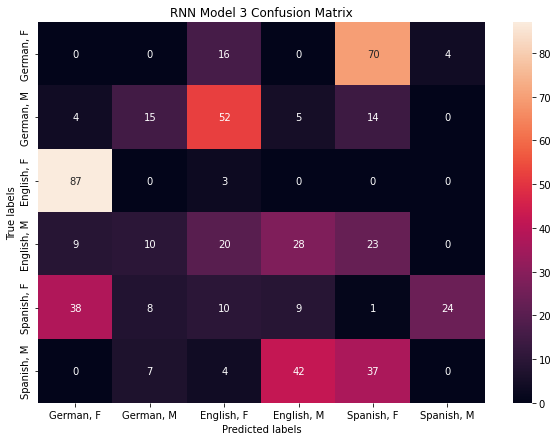

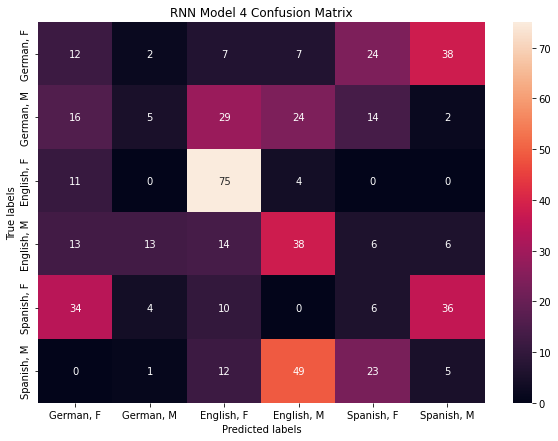

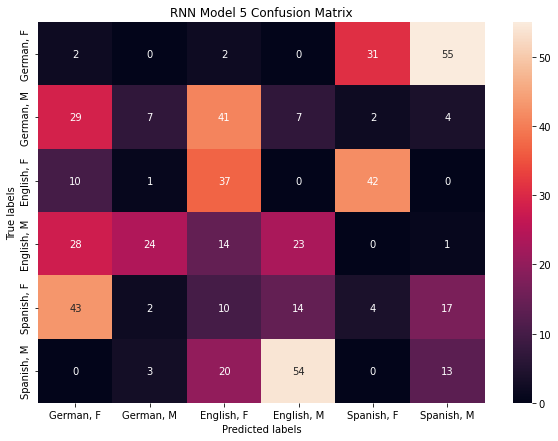

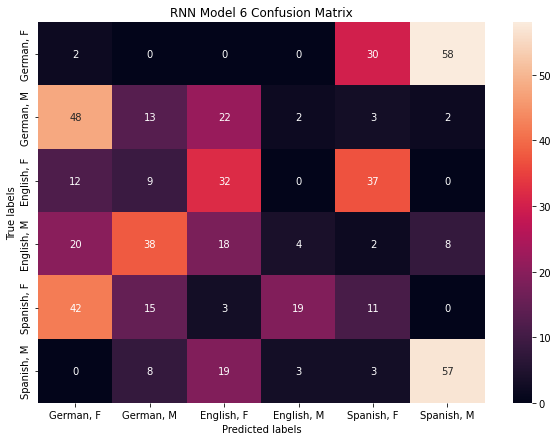

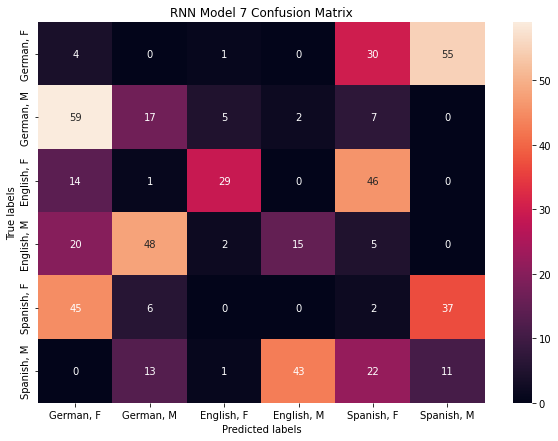

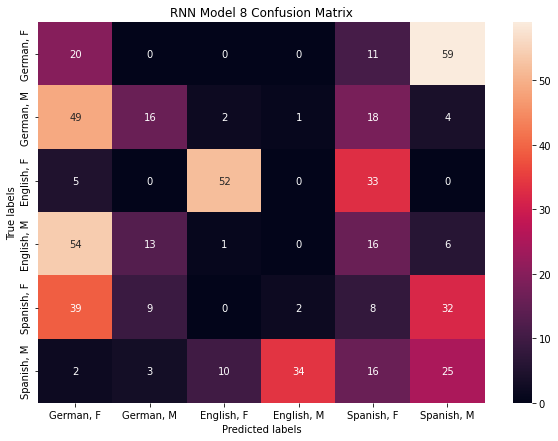

In [26]:
# RNN Models

test_accuracy(rnn_model_1, 'RNN Model 1')
test_accuracy(rnn_model_2, 'RNN Model 2')
test_accuracy(rnn_model_3, 'RNN Model 3')
test_accuracy(rnn_model_4, 'RNN Model 4')
test_accuracy(rnn_model_5, 'RNN Model 5')
test_accuracy(rnn_model_6, 'RNN Model 6')
test_accuracy(rnn_model_7, 'RNN Model 7')
test_accuracy(rnn_model_8, 'RNN Model 8')

# Sample Prediction

In [ ]:
def predict_demo(file_name):

  demo_path = "drive/MyDrive/DL1/DL1_audio/Input data/Demo/"
  demo_audio = np.load(demo_path+file_name+'.npy')

  predictions = model.predict(demo_audio)
  classes = np.argmax(predictions, axis = 1)

  Dict = {0: 'Language: German, Gender: Female',
        1: 'Language: German, Gender: Male',
        2: 'Language: English, Gender: Female',
        3: 'Language: English, Gender: Male',
        4: 'Language: Spanish, Gender: Female',
        5: 'Language: Spanish, Gender: Male',
       }
       
  print('Prediction\n>>>', Dict[classes[0]])

In [ ]:
def predict_sample(file_name):

  sample_path = "drive/MyDrive/DL1/DL1_audio/Input data/Sample/"

  sample_audio = np.load(sample_path+file_name+'.npy')

  predictions = model.predict(sample_audio)
  classes = np.argmax(predictions, axis = 1)

  Dict = {0: 'Language: German, Gender: Female',
        1: 'Language: German, Gender: Male',
        2: 'Language: English, Gender: Female',
        3: 'Language: English, Gender: Male',
        4: 'Language: Spanish, Gender: Female',
        5: 'Language: Spanish, Gender: Male',
       }
       
  print('Prediction\n>>>', Dict[classes[0]])

In [ ]:
# path to sample files

sample_path = "drive/MyDrive/DL1/DL1_audio/Input data/Sample/"

In [ ]:
import IPython.display as ipd

# Sample Predictions

In [ ]:
# Spanish Male

ipd.Audio(sample_path+'money_heist.wav')

In [ ]:
predict_sample('money_heist')

Prediction
>>> Language: Spanish, Gender: Female


In [ ]:
# German Female

ipd.Audio(sample_path+'german_1.wav')

In [ ]:
predict_sample('german_1')

Prediction
>>> Language: German, Gender: Female


# Demo

In [ ]:
def record_sample(file_name):
    
    import sounddevice as sd
    from scipy.io.wavfile import write
    import time
    sd.default.dtype=('int32')

    sr = 22050 
    seconds = 10  
    print("Recording...")
    record_voice = sd.rec(int(seconds *sr) , samplerate = sr, channels = 2)
    
    for i in range(10,0,-1):
        time.sleep(1)
        print(i)
    
    sd.wait()
    
    write(sample_path+file_name+".wav",sr,record_voice)
    print("Recording Finished")

In [ ]:
def preprocess_sample(file_name):
    
    # load sample audio
    time_series_sample = []
    num_samples_sample = []
    data, samplerate = librosa.load(demo_path+file_name+".wav")
    time_series_sample.append(data)
    num_samples_sample.append(samplerate)
        
    
    #combined MFCC    
    scaler = StandardScaler()
    
    mfcc_delta2_sample = []
    for i in range(0, len(time_series_sample)):
        mfcc_d = librosa.feature.mfcc(time_series_sample[i], sr=num_samples_sample[i])
        mfcc_delta = librosa.feature.delta(mfcc_d)
        mfcc_delta_delta = librosa.feature.delta(mfcc_d, order=2)
        combined_mfcc_delta = np.concatenate((mfcc_d, mfcc_delta, mfcc_delta_delta))
        combined_mfcc_delta_sc = scaler.fit_transform(combined_mfcc_delta)
        mfcc_delta2_sample.append(combined_mfcc_delta_sc)
    mfcc_delta2_sample = np.array(mfcc_delta2_sample)
        
        
    return mfcc_delta2_sample

In [ ]:
def save_sample(file_name):
    np.save(demo_path+file_name+'.npy', sample)

In [ ]:
def speech_to_text(language):
    
    # Speech to text
    import speech_recognition as sr

    AUDIO_FILE = (sample_path+'demo.wav')

    # use the audio file as the audio source
    r = sr.Recognizer()

    print("\n\nConverting to text...")
    with sr.AudioFile(AUDIO_FILE) as source:
        audio = r.record(source)  # read the entire audio file

    print('\n>>>>>>>> ', r.recognize_google(audio, language=language))

# Demo Recording

In [ ]:
# path to save demo file

demo_path = "drive/MyDrive/DL1/DL1_audio/Input data/Demo"

In [ ]:
# record Spanish

record_sample('demo')

# preprocess and save
sample = preprocess_sample('demo')
save_sample('demo')

# convert audio to text 
speech_to_text('es-ES')

In [ ]:
# record English

record_sample('demo')

# preprocess and save
sample = preprocess_sample('demo')
save_sample('demo')

# convert audio to text
speech_to_text('en-US')

In [ ]:
# record German

record_sample('demo')

# preprocess and save
sample = preprocess_sample('demo')
save_sample('demo')

# convert audio to text
speech_to_text('de-DE')

# Demo Prediction

In [ ]:
path = "drive/MyDrive/DL1/DL1_audio/Input data/"

In [ ]:
# load chosen model

model = load_model(path+'CNN Models/Model 1/', compile = True)

In [ ]:
# Spanish Female

predict_demo('demo')

Prediction
>>> Language: Spanish, Gender: Female
